## **1. Introduction to the Dataset**

The **Low-Light Agricultural Dataset** is a collection of images captured in a macadamia orchard in McLeans Ridges, NSW, Australia. Despite being recorded on a sunny day, the images are underexposed due to shading from trees. This dataset provides a valuable resource for developing and testing computer vision algorithms in challenging low-light conditions common in agricultural environments.

**Key Features:**

- **Underexposed Images**: Represents real-world low-light scenarios in agriculture.
- **Stereo Images**: Contains left and right images for stereo vision applications.
- **Depth Data**: Includes depth maps corresponding to the left images.
- **Calibration Files**: Provides camera parameters necessary for image processing.
- **SVO File**: Contains raw synchronized stereo video and sensor data (requires ZED SDK).

---

## **2. Understanding the Dataset Contents**

The dataset comprises three main components:

1. **Left + Right Images**:
   - **Description**: Stereo image pairs from left and right cameras.
   - **Contents**: Two folders named `left` and `right`, each containing 2,146 images.

2. **Left + Depth Data**:
   - **Description**: Left camera images paired with depth information.
   - **Contents**: Two folders named `left` and `depth`.

3. **SVO Raw File**:
   - **Description**: A `.svo` file containing raw compressed stereo video.
   - **File**: `raw_compressed.svo` (requires ZED SDK for processing).

**Calibration Files**:

- Each component includes a calibration file (`calibration_left_right.conf`, etc.) containing camera intrinsic and extrinsic parameters needed for image undistortion and rectification.

---

## **3. Potential Applications**

The dataset is suitable for various computer vision tasks, particularly those involving low-light conditions:

- **Image Enhancement**: Improving the quality of underexposed images.
- **Stereo Vision and Depth Estimation**: Estimating depth from stereo image pairs.
- **Object Detection and Segmentation**: Identifying and segmenting objects like trees and fruits.
- **Autonomous Navigation**: Developing navigation algorithms for agricultural robots.


In [1]:
pip install opencv-python opencv-contrib-python numpy

Note: you may need to restart the kernel to use updated packages.



## **4. Loading and Exploring the Dataset**

### **A. Directory Structure**


```
dataset/
├── calibration_left_right.conf
├── left/
│   ├── left000000.png
│   ├── left000001.png
│   └── ...
└── right/
    ├── right000000.png
    ├── right000001.png
    └── ...
```

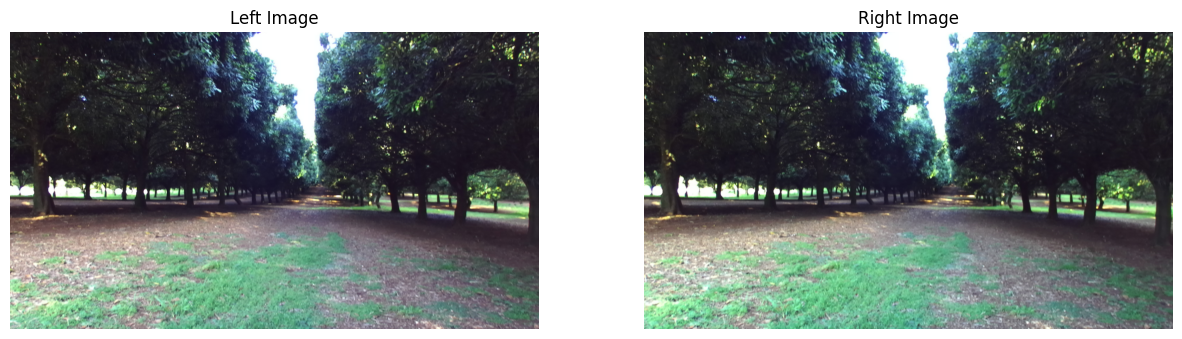

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

left_image_dir = 'left+right/left'
right_image_dir = 'left+right/right'

left_images = sorted(glob.glob(os.path.join(left_image_dir, '*.png')))
right_images = sorted(glob.glob(os.path.join(right_image_dir, '*.png')))

assert len(left_images) == len(right_images), "Mismatch in number of images."

# Load a sample pair of images
img_left = cv2.imread(left_images[0], cv2.IMREAD_COLOR)
img_right = cv2.imread(right_images[0], cv2.IMREAD_COLOR)

# Convert images from BGR to RGB
img_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_left_rgb)
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_right_rgb)
plt.title('Right Image')
plt.axis('off')

plt.show()


- **`glob.glob`**: Retrieves file paths matching a pattern.
- **`cv2.imread`**: Loads an image from a file.
- **Color Conversion**: OpenCV uses BGR; we convert to RGB for correct display with Matplotlib.
- **Visualization**: Displays left and right images side by side.

---

## **5. Parsing and Using the Calibration Files**

The calibration files provide the camera parameters required for undistorting and rectifying images.

### **A. Parsing the Calibration File**


In [4]:
def parse_calibration_file(filepath):
    calibration_data = {}
    current_section = None

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('[') and line.endswith(']'):
                current_section = line[1:-1]
                calibration_data[current_section] = {}
            elif '=' in line and current_section:
                key, value = line.split('=')
                calibration_data[current_section][key.strip()] = float(value.strip())
    return calibration_data

# Parse the calibration file
calibration_file_path = 'calibration_left_right.conf'
calibration_data = parse_calibration_file(calibration_file_path)

- **Function**: Reads the calibration file and stores parameters in a dictionary.
- **Sections**: Each camera and resolution has its own section (e.g., `[LEFT_CAM_2K]`).

### **B. Extracting Camera Parameters**


In [5]:

def get_camera_parameters(calibration_data, resolution='2K'):
    left_cam_key = f'LEFT_CAM_{resolution}'
    right_cam_key = f'RIGHT_CAM_{resolution}'
    stereo_key = 'STEREO'

    # Left camera intrinsic parameters
    K_left = np.array([
        [calibration_data[left_cam_key]['fx'], 0, calibration_data[left_cam_key]['cx']],
        [0, calibration_data[left_cam_key]['fy'], calibration_data[left_cam_key]['cy']],
        [0, 0, 1]
    ])
    dist_left = np.array([
        calibration_data[left_cam_key]['k1'],
        calibration_data[left_cam_key]['k2'],
        calibration_data[left_cam_key]['p1'],
        calibration_data[left_cam_key]['p2'],
        calibration_data[left_cam_key]['k3']
    ])

    # Right camera intrinsic parameters
    K_right = np.array([
        [calibration_data[right_cam_key]['fx'], 0, calibration_data[right_cam_key]['cx']],
        [0, calibration_data[right_cam_key]['fy'], calibration_data[right_cam_key]['cy']],
        [0, 0, 1]
    ])
    dist_right = np.array([
        calibration_data[right_cam_key]['k1'],
        calibration_data[right_cam_key]['k2'],
        calibration_data[right_cam_key]['p1'],
        calibration_data[right_cam_key]['p2'],
        calibration_data[right_cam_key]['k3']
    ])

    # Stereo extrinsic parameters
    baseline = calibration_data[stereo_key]['Baseline'] / 1000.0  # Convert mm to meters
    T = np.array([[-baseline, 0, 0]]).T  # Translation vector
    R = np.eye(3)  # Assuming no rotation between cameras

    return K_left, dist_left, K_right, dist_right, R, T

# Get the camera parameters
K_left, dist_left, K_right, dist_right, R, T = get_camera_parameters(calibration_data, resolution='2K')


- **Intrinsic Parameters**: Focal lengths (`fx`, `fy`) and principal points (`cx`, `cy`).
- **Distortion Coefficients**: Radial and tangential distortion parameters (`k1`, `k2`, `p1`, `p2`, `k3`).
- **Extrinsic Parameters**: Relative position and orientation between the cameras.

---

## **6. Image Preprocessing**

### **A. Undistort and Rectify Images**

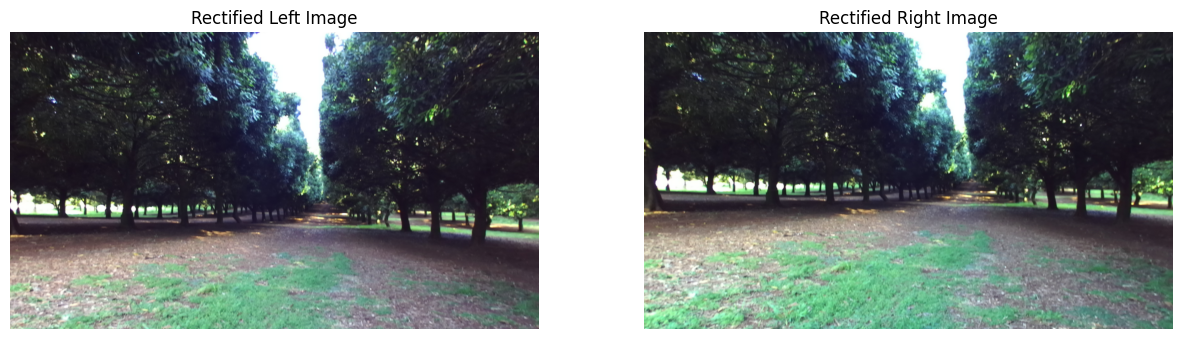

In [6]:

# Image dimensions
h, w = img_left.shape[:2]

# Stereo rectification
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K_left, dist_left, K_right, dist_right, (w, h), R, T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

# Compute rectification maps
left_map1, left_map2 = cv2.initUndistortRectifyMap(
    K_left, dist_left, R1, P1, (w, h), cv2.CV_16SC2
)
right_map1, right_map2 = cv2.initUndistortRectifyMap(
    K_right, dist_right, R2, P2, (w, h), cv2.CV_16SC2
)

# Remap images
rectified_left = cv2.remap(img_left, left_map1, left_map2, interpolation=cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_right, right_map1, right_map2, interpolation=cv2.INTER_LINEAR)

# Convert to RGB
rectified_left_rgb = cv2.cvtColor(rectified_left, cv2.COLOR_BGR2RGB)
rectified_right_rgb = cv2.cvtColor(rectified_right, cv2.COLOR_BGR2RGB)

# Display rectified images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(rectified_left_rgb)
plt.title('Rectified Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rectified_right_rgb)
plt.title('Rectified Right Image')
plt.axis('off')

plt.show()

- **`cv2.stereoRectify`**: Computes rectification transforms for both cameras.
- **`cv2.initUndistortRectifyMap`**: Computes the undistortion and rectification transformation map.
- **`cv2.remap`**: Applies the transformation to the images.

### **B. Verify Alignment**

To ensure images are correctly rectified, we can overlay horizontal lines.

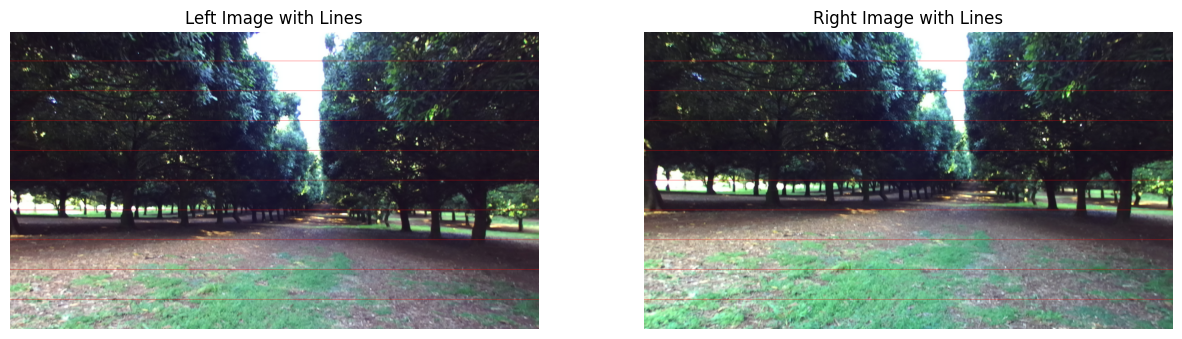

In [7]:
def draw_horizontal_lines(img, num_lines=10):
    img_with_lines = img.copy()
    h, w = img.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        cv2.line(img_with_lines, (0, y), (w, y), (255, 0, 0), 1)
    return img_with_lines

# Draw lines
left_with_lines = draw_horizontal_lines(rectified_left_rgb)
right_with_lines = draw_horizontal_lines(rectified_right_rgb)

# Display images with lines
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(left_with_lines)
plt.title('Left Image with Lines')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(right_with_lines)
plt.title('Right Image with Lines')
plt.axis('off')

plt.show()

- **Function**: Draws equally spaced horizontal lines on images.
- **Purpose**: Helps visualize if corresponding points align horizontally.

---

## **7. Depth Estimation Using Stereo Vision**

### **A. Convert Images to Grayscale**


In [8]:
# Convert images to grayscale
gray_left = cv2.cvtColor(rectified_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(rectified_right, cv2.COLOR_BGR2GRAY)

### **B. Compute Disparity Map**

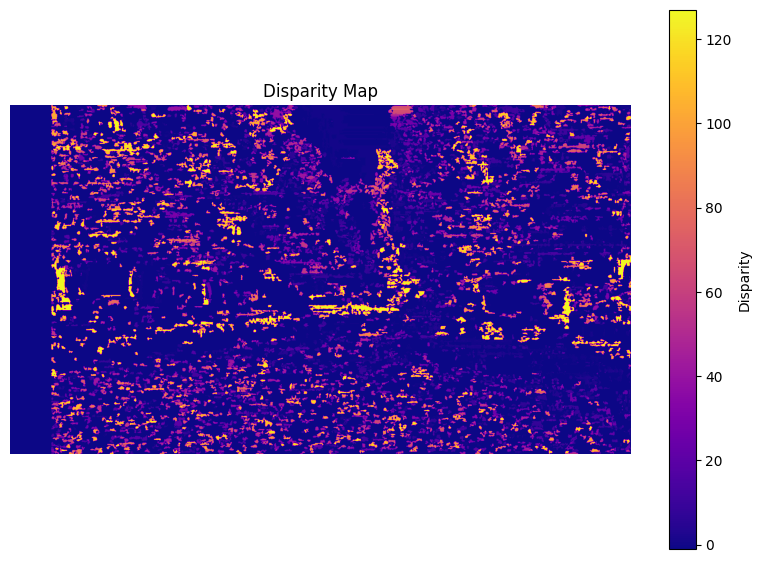

In [9]:
# StereoSGBM matcher parameters
min_disp = 0
num_disp = 16 * 8  # Must be divisible by 16
block_size = 7

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=50,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute disparity map
disparity = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

# Display disparity map
plt.figure(figsize=(10, 7))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparity')
plt.title('Disparity Map')
plt.axis('off')
plt.show()

- **`StereoSGBM`**: Semi-Global Block Matching algorithm for computing disparity.
- **Parameters**: Tweak parameters like `numDisparities`, `blockSize`, and `uniquenessRatio` for optimal results.
- **Normalization**: Dividing by 16.0 adjusts for fixed-point arithmetic in OpenCV.

### **C. Compute Depth Map**

/tmp/ipykernel_426/2673937945.py:8: RuntimeWarning: divide by zero encountered in divide
  depth_map[valid_disp_mask] = (focal_length * baseline) / disparity[valid_disp_mask]


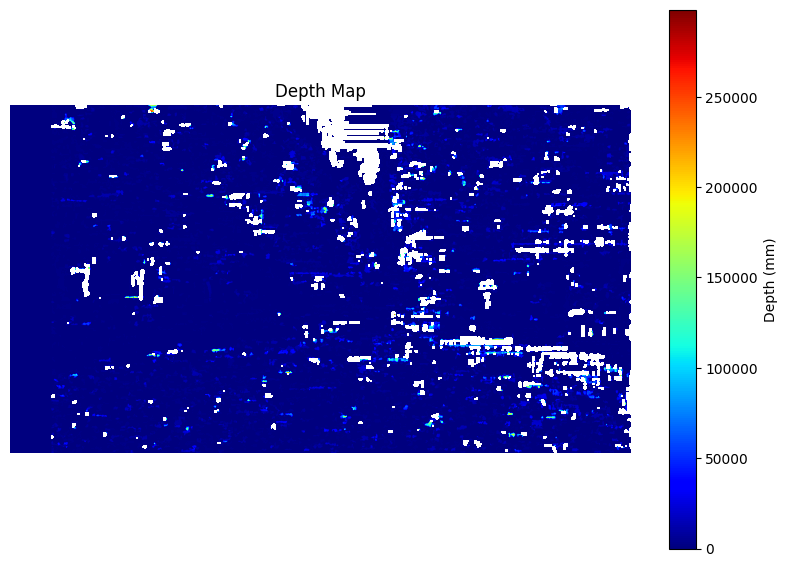

In [10]:
# Mask disparity values
valid_disp_mask = disparity > disparity.min()

# Compute depth map
focal_length = K_left[0, 0]
baseline = abs(T[0][0]) * 1000  # Convert meters to millimeters
depth_map = np.zeros(disparity.shape, np.float32)
depth_map[valid_disp_mask] = (focal_length * baseline) / disparity[valid_disp_mask]

# Display depth map
plt.figure(figsize=(10, 7))
plt.imshow(depth_map, cmap='jet')
plt.colorbar(label='Depth (mm)')
plt.title('Depth Map')
plt.axis('off')
plt.show()

- **Depth Calculation**: \( \text{Depth} = \frac{f \times B}{\text{Disparity}} \)
- **Masking**: Excludes invalid disparity values from calculations.
- **Visualization**: Displays depth map using a colormap for better interpretation.

---

## **8. Visualizing the Results**

### **A. Overlay Depth Map on Image**

/tmp/ipykernel_426/2005760159.py:3: RuntimeWarning: invalid value encountered in cast
  depth_normalized = depth_normalized.astype(np.uint8)


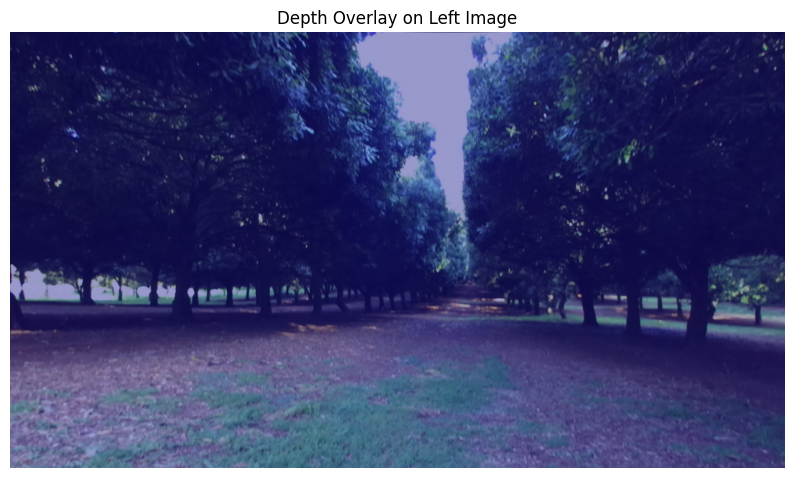

In [11]:
# Normalize depth map for visualization
depth_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_normalized = depth_normalized.astype(np.uint8)

# Apply colormap
depth_colormap = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_JET)

# Overlay on left image
overlay = cv2.addWeighted(rectified_left, 0.6, depth_colormap, 0.4, 0)

# Convert to RGB for display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display overlay
plt.figure(figsize=(10, 7))
plt.imshow(overlay_rgb)
plt.title('Depth Overlay on Left Image')
plt.axis('off')
plt.show()

- **Normalization**: Scales depth values to 8-bit range for visualization.
- **Colormap**: Applies a color mapping to represent depth values visually.
- **Overlay**: Combines the color-mapped depth image with the original image.

### **B. Generate 3D Point Cloud (Optional)**

In [12]:
# Reproject to 3D space
points_3D = cv2.reprojectImageTo3D(disparity, Q)
mask = disparity > disparity.min()

# Extract valid points and colors
output_points = points_3D[mask]
output_colors = rectified_left[mask]

# Save to PLY file
def save_point_cloud(filename, points, colors):
    with open(filename, 'w') as file:
        # Header
        file.write('ply\nformat ascii 1.0\nelement vertex {}\n'.format(len(points)))
        file.write('property float x\nproperty float y\nproperty float z\n')
        file.write('property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n')
        # Data
        for p, c in zip(points, colors):
            file.write('{} {} {} {} {} {}\n'.format(p[0], p[1], p[2], c[2], c[1], c[0]))

save_point_cloud('output_point_cloud.ply', output_points, output_colors)

- **`cv2.reprojectImageTo3D`**: Converts disparity map to 3D point cloud.
- **PLY File**: A standard format for storing 3D data, viewable in tools like MeshLab.
- **Color Information**: Includes color data from the image for realistic visualization.

---

## **Conclusion**

Till here, we've:

- **Explored the Dataset**: Loaded and visualized stereo image pairs.
- **Used Calibration Data**: Parsed calibration files and extracted camera parameters.
- **Preprocessed Images**: Undistorted and rectified images for accurate stereo matching.
- **Estimated Depth**: Computed disparity and depth maps using stereo vision techniques.
- **Visualized Results**: Displayed disparity and depth maps, and generated a 3D point cloud.

## **9. Image Enhancement**

Improving the quality of underexposed images is crucial for better performance in depth estimation, segmentation, and other computer vision tasks. We'll explore several image enhancement techniques.

### **A. Histogram Equalization**

Histogram Equalization enhances the contrast of images by spreading out the most frequent intensity values.

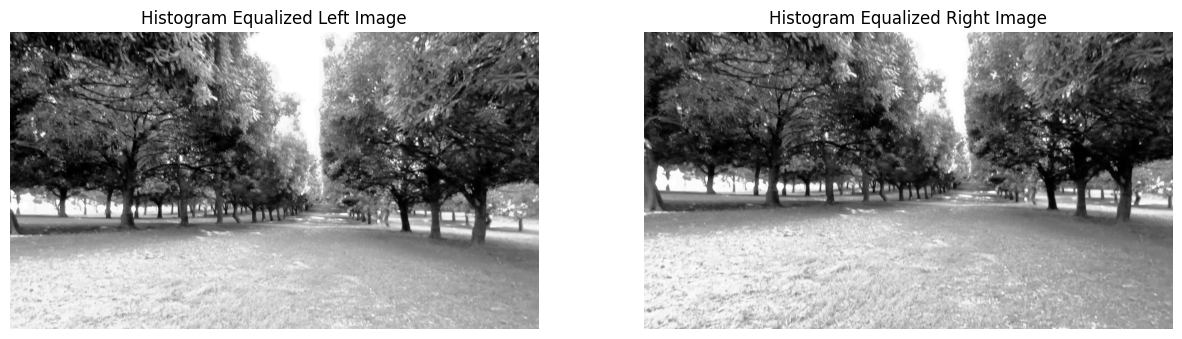

In [13]:
# Convert the rectified images to grayscale (if not already)
gray_left = cv2.cvtColor(rectified_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(rectified_right, cv2.COLOR_BGR2GRAY)

# Apply Histogram Equalization
equalized_left = cv2.equalizeHist(gray_left)
equalized_right = cv2.equalizeHist(gray_right)

# Display the enhanced images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(equalized_left, cmap='gray')
plt.title('Histogram Equalized Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(equalized_right, cmap='gray')
plt.title('Histogram Equalized Right Image')
plt.axis('off')

plt.show()

- **`cv2.equalizeHist`** improves the contrast by equalizing the histogram of the grayscale image.
- This can make features more distinguishable in low-light conditions.

### **B. Adaptive Histogram Equalization (CLAHE)**

Contrast Limited Adaptive Histogram Equalization (CLAHE) applies histogram equalization in small regions (tiles) and limits amplification of noise.

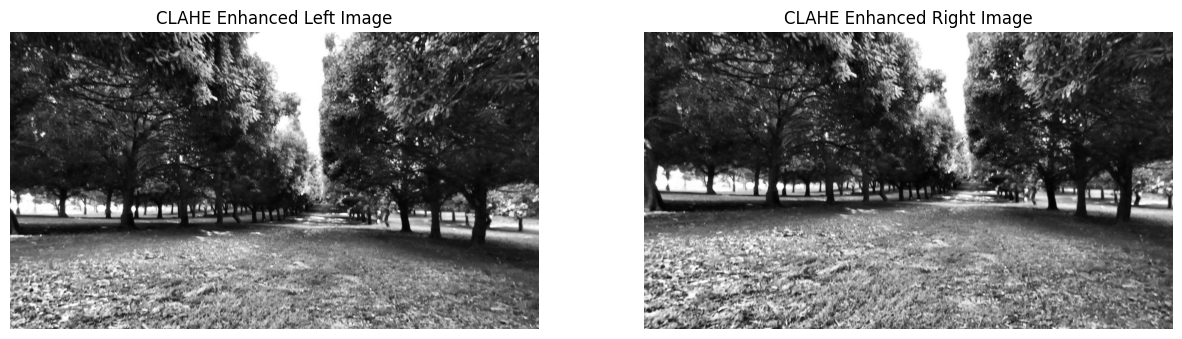

In [14]:
# Create a CLAHE object with a clip limit and grid size
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the grayscale images
clahe_left = clahe.apply(gray_left)
clahe_right = clahe.apply(gray_right)

# Display the enhanced images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(clahe_left, cmap='gray')
plt.title('CLAHE Enhanced Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clahe_right, cmap='gray')
plt.title('CLAHE Enhanced Right Image')
plt.axis('off')

plt.show()

- **`cv2.createCLAHE`** creates a CLAHE object with specified parameters.
- **`clipLimit`** prevents over-amplification of noise.
- **`tileGridSize`** defines the size of the grid for the local histogram equalization.

### **C. Gamma Correction**

Adjusts the brightness of the image.

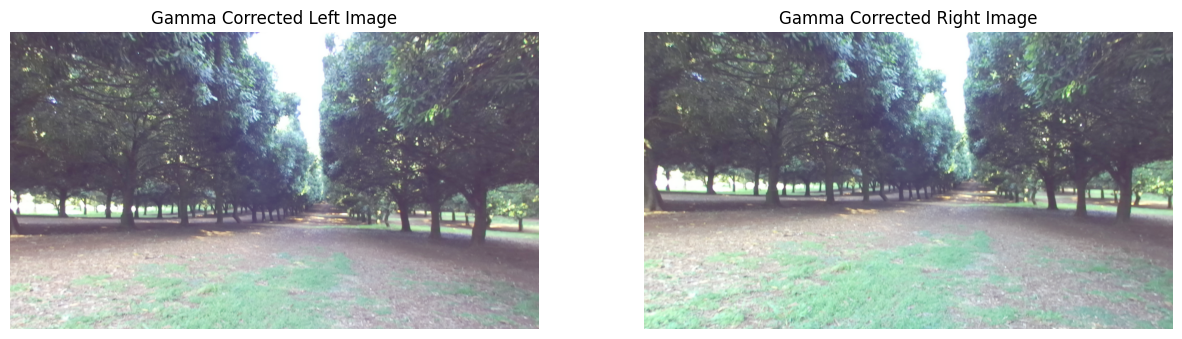

In [15]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    # Build a lookup table mapping pixel values [0, 255] to adjusted gamma values
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)

# Apply gamma correction
gamma_corrected_left = adjust_gamma(rectified_left, gamma=2.0)
gamma_corrected_right = adjust_gamma(rectified_right, gamma=2.0)

# Display the gamma-corrected images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(gamma_corrected_left, cv2.COLOR_BGR2RGB))
plt.title('Gamma Corrected Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gamma_corrected_right, cv2.COLOR_BGR2RGB))
plt.title('Gamma Corrected Right Image')
plt.axis('off')

plt.show()

- **Gamma Values**: Values >1 make the image brighter; values <1 make it darker.

### **D. Combining Enhancement Techniques**

You can combine these techniques for better results.

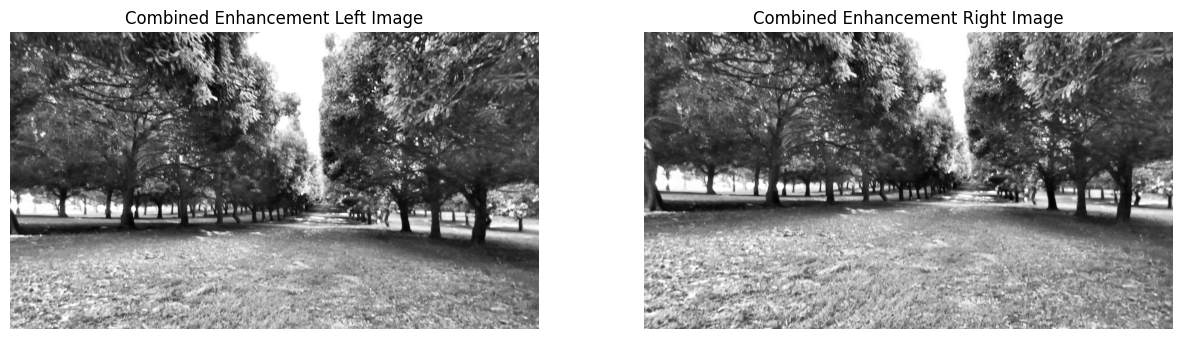

In [16]:
# Apply CLAHE to the grayscale images
enhanced_left = clahe.apply(gray_left)
enhanced_right = clahe.apply(gray_right)

# Apply gamma correction to the original images
gamma_corrected_left = adjust_gamma(rectified_left, gamma=2.0)
gamma_corrected_right = adjust_gamma(rectified_right, gamma=2.0)

# Convert gamma-corrected images to grayscale
gamma_corrected_gray_left = cv2.cvtColor(gamma_corrected_left, cv2.COLOR_BGR2GRAY)
gamma_corrected_gray_right = cv2.cvtColor(gamma_corrected_right, cv2.COLOR_BGR2GRAY)

# Combine CLAHE and gamma correction
combined_left = clahe.apply(gamma_corrected_gray_left)
combined_right = clahe.apply(gamma_corrected_gray_right)

# Display the combined enhanced images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(combined_left, cmap='gray')
plt.title('Combined Enhancement Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(combined_right, cmap='gray')
plt.title('Combined Enhancement Right Image')
plt.axis('off')

plt.show()

### **E. Recomputing Disparity with Enhanced Images**

Compute the disparity map using the enhanced images.

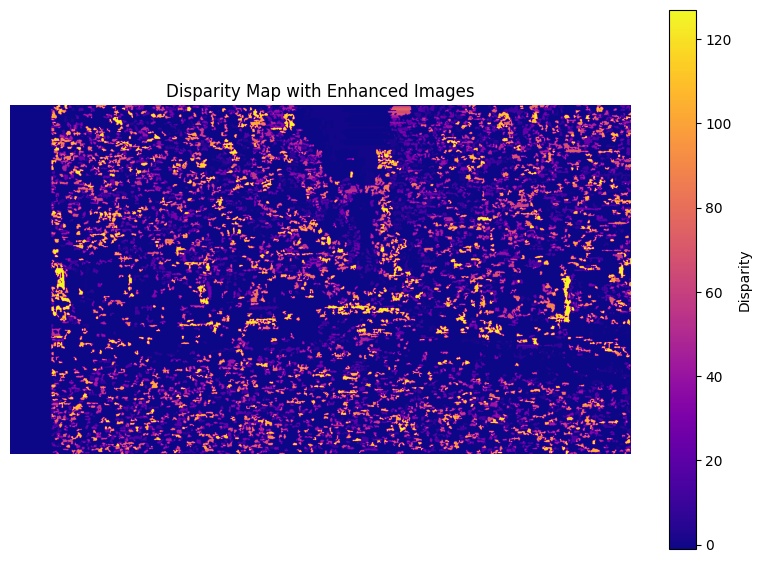

In [17]:
# Use the combined enhanced images
disparity_enhanced = stereo.compute(combined_left, combined_right).astype(np.float32) / 16.0

# Display the disparity map
plt.figure(figsize=(10, 7))
plt.imshow(disparity_enhanced, cmap='plasma')
plt.colorbar(label='Disparity')
plt.title('Disparity Map with Enhanced Images')
plt.axis('off')
plt.show()

**Comparison**:

- Compare the disparity maps before and after enhancement to see the improvement in detail and reduction of noise.

---

## **10. Algorithm Optimization**

Fine-tuning the stereo matching algorithm's parameters can enhance the quality of the disparity map.

### **A. Understanding StereoSGBM Parameters**

Key parameters to adjust:

- **`minDisparity`**: The minimum possible disparity value.
- **`numDisparities`**: The range of disparity values. Must be divisible by 16.
- **`blockSize`**: The size of the matching block.
- **`P1`** and **`P2`**: Penalties controlling the smoothness of the disparity map.
- **`uniquenessRatio`**: Filters out weak matches.
- **`speckleWindowSize`** and **`speckleRange`**: Removes small noise blobs.

### **B. Parameter Tuning**

Experiment with different parameter values.

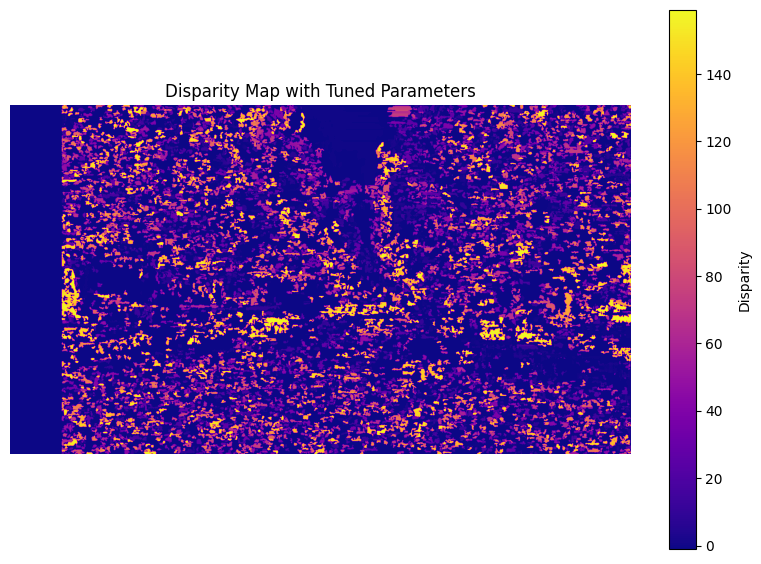

In [18]:
# Create a new StereoSGBM object with tuned parameters
stereo_tuned = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*10,  # Increased number of disparities
    blockSize=9,           # Larger block size
    P1=8 * 3 * 9**2,
    P2=32 * 3 * 9**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,    # Adjusted uniqueness ratio
    speckleWindowSize=50,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute disparity with tuned parameters
disparity_tuned = stereo_tuned.compute(combined_left, combined_right).astype(np.float32) / 16.0

# Display the tuned disparity map
plt.figure(figsize=(10, 7))
plt.imshow(disparity_tuned, cmap='plasma')
plt.colorbar(label='Disparity')
plt.title('Disparity Map with Tuned Parameters')
plt.axis('off')
plt.show()

- **Increased `numDisparities`**: Allows for detecting objects at farther distances.
- **Adjusted `blockSize`**: Balances detail and noise.
- **Fine-tune other parameters** based on the observed results.

### **C. Evaluating the Improvements**

- **Qualitative Analysis**: Visually inspect the disparity map for clarity and consistency.
- **Quantitative Metrics**: If ground truth is available, compute metrics like MAE or RMSE.

---

## **11. Machine Learning Applications**

Leveraging machine learning models can improve depth estimation, segmentation, and object detection.

### **A. Depth Estimation with Neural Networks**

#### **1. Monocular Depth Estimation**

- **Objective**: Estimate depth from a single image.
- **Models**: Use pre-trained models like **Monodepth2**.

In [19]:
pip install monodepth2

Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
from monodepth2 import networks
from PIL import Image
from torchvision import transforms

# Load a pre-trained model
model = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=model.num_ch_enc, scales=range(4))

# Load model weights
model_path = "mono_1024x320"
model.load_state_dict(torch.load(os.path.join(model_path, "encoder.pth")))
depth_decoder.load_state_dict(torch.load(os.path.join(model_path, "depth.pth")))

# Set to evaluation mode
model.eval()
depth_decoder.eval()

# Prepare the image
input_image = Image.fromarray(cv2.cvtColor(rectified_left, cv2.COLOR_BGR2RGB))
original_width, original_height = input_image.size
feed_height = 192
feed_width = 640

transform = transforms.Compose([
    transforms.Resize((feed_height, feed_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225))
])

input_image = transform(input_image).unsqueeze(0)

# Predict depth
with torch.no_grad():
    features = model(input_image)
    outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(
        disp, (original_height, original_width), mode="bilinear", align_corners=False
    )

# Convert to numpy array
disp_resized_np = disp_resized.squeeze().cpu().numpy()

# Display the depth map
plt.figure(figsize=(10, 7))
plt.imshow(disp_resized_np, cmap='plasma')
plt.colorbar(label='Depth')
plt.title('Monocular Depth Estimation')
plt.axis('off')
plt.show()

/tmp/ipykernel_426/2091247242.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "encoder.pth")))


RuntimeError: Error(s) in loading state_dict for ResnetEncoder:
	Unexpected key(s) in state_dict: "height", "width", "use_stereo". 

- **Monodepth2**: A state-of-the-art model for monocular depth estimation.
- **Pre-trained Models**: Use models trained on large datasets to get reasonable results.

#### **2. Training a Depth Estimation Model**

- **Data Preparation**: Use stereo pairs to generate disparity/depth maps as training data.
- **Model Architecture**: Use U-Net, ResNet, or more complex architectures.
- **Loss Functions**: Combine reconstruction loss, edge-aware smoothness loss, etc.

### **B. Semantic Segmentation**

#### **1. Preparing the Dataset**

- **Annotation**: Manually label images to create segmentation masks.
- **Classes**: Define classes relevant to your application (e.g., trees, ground, sky).

#### **2. Using Pre-trained Models**

- **SegFormer**: Efficient and accurate model for segmentation.

In [ ]:
pip install transformers

In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image

# Load a pre-trained SegFormer model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Prepare the image
image = Image.fromarray(cv2.cvtColor(rectified_left, cv2.COLOR_BGR2RGB))
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, num_classes, height, width)

# Get predicted segmentation map
segmentation = logits.argmax(dim=1).squeeze().cpu().numpy()

# Display the segmentation map
plt.figure(figsize=(10, 7))
plt.imshow(segmentation)
plt.title('Semantic Segmentation')
plt.axis('off')
plt.show()

- **SegFormer**: Transformer-based model for efficient segmentation.
- **Feature Extractor**: Preprocesses the image for the model.

#### **3. Fine-tuning the Model**

- **Custom Dataset**: Fine-tune the model on your annotated dataset for better performance.
- **Training Loop**: Implement a training loop using PyTorch, define loss functions (e.g., Cross-Entropy Loss).

---

## **12. Real-World Application**

Integrating the computer vision pipeline into an agricultural robot or system.

### **A. Autonomous Navigation**

- **Objective**: Use depth and segmentation data for path planning and obstacle avoidance.

### **B. Integrating with ROS**

**ROS (Robot Operating System)** is widely used for robotics applications.

#### **1. Setting Up ROS**

- Install ROS on your system (e.g., ROS Noetic on Ubuntu 20.04).

#### **2. Creating ROS Nodes**

- **Publisher Node**: Publishes images from the camera.
- **Processing Node**: Subscribes to the image topic, processes images (e.g., depth estimation), and publishes results.

In [ ]:
# ROS Publisher Node (simplified)
import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

def image_publisher():
    rospy.init_node('image_publisher', anonymous=True)
    pub = rospy.Publisher('camera/image_raw', Image, queue_size=10)
    rate = rospy.Rate(10)  # 10 Hz
    bridge = CvBridge()
    cap = cv2.VideoCapture(0)  # Capture from camera

    while not rospy.is_shutdown():
        ret, frame = cap.read()
        if ret:
            msg = bridge.cv2_to_imgmsg(frame, encoding="bgr8")
            pub.publish(msg)
        rate.sleep()

if __name__ == '__main__':
    try:
        image_publisher()
    except rospy.ROSInterruptException:
        pass

#### **3. Processing Node**

- Subscribes to `camera/image_raw`.
- Performs processing (e.g., depth estimation).
- Publishes results to another topic.

### **C. Hardware Deployment**

- **Edge Devices**: Use devices like NVIDIA Jetson Nano or Xavier.
- **Optimization**: Use TensorRT for model optimization to achieve real-time performance.

### **D. Field Testing**

- **Simulations**: Use Gazebo or other simulation tools to test in a virtual environment.
- **Real-world Testing**: Deploy the system in the field, ensuring safety protocols are in place.

---

## **13. Additional Considerations**

### **A. Performance Evaluation**

- **Metrics**:
  - **Depth Estimation**: Use metrics like Absolute Relative Difference, RMSE.
  - **Segmentation**: Mean Intersection over Union (mIoU), Pixel Accuracy.
- **Benchmarking**: Compare with baseline methods.

### **B. Data Augmentation**

- **Techniques**: Random flips, rotations, brightness/contrast adjustments.
- **Purpose**: Increase dataset variability to improve model robustness.

### **C. Ethical and Safety Concerns**

- **Data Privacy**: Ensure no personal or sensitive information is captured.
- **Safety**: Implement fail-safes in autonomous systems to prevent accidents.

### **D. Documentation and Reproducibility**

- **Code Documentation**: Comment code and provide clear explanations.
- **Version Control**: Use Git for code management.
- **Reproducibility**: Share datasets, code, and models when possible.

---

## **Conclusion**

- **Experimentation**: Try different models and techniques to see what works best for your specific use case.
- **Collaboration**: Engage with communities or research groups for knowledge sharing.
- **Continuous Learning**: Stay updated with the latest advancements in computer vision and machine learning.